In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graphviz
from matplotlib.colors import ListedColormap
from sklearn import tree, datasets
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import kagglehub
import warnings
warnings.filterwarnings("ignore")

d:\BDS3\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 📘 What is a Decision Tree?

A **decision tree** is a type of supervised learning algorithm used for classification and regression. It uses a tree-like structure to make decisions based on input features. Each internal node of the tree tests a feature, each branch corresponds to the result of the test, and each leaf node represents a class label or prediction.

Let’s consider an example. Suppose a doctor is diagnosing whether a tumor is malignant or benign. She might first ask:
- *"Is the mean radius of the tumor greater than 14?"*
  - If **no**, the tumor might be **benign**.
  - If **yes**, she might next ask: *"What is the texture score?"*

The process continues until the doctor feels confident in making a decision. Decision trees automate this reasoning by identifying the best splits at each level.



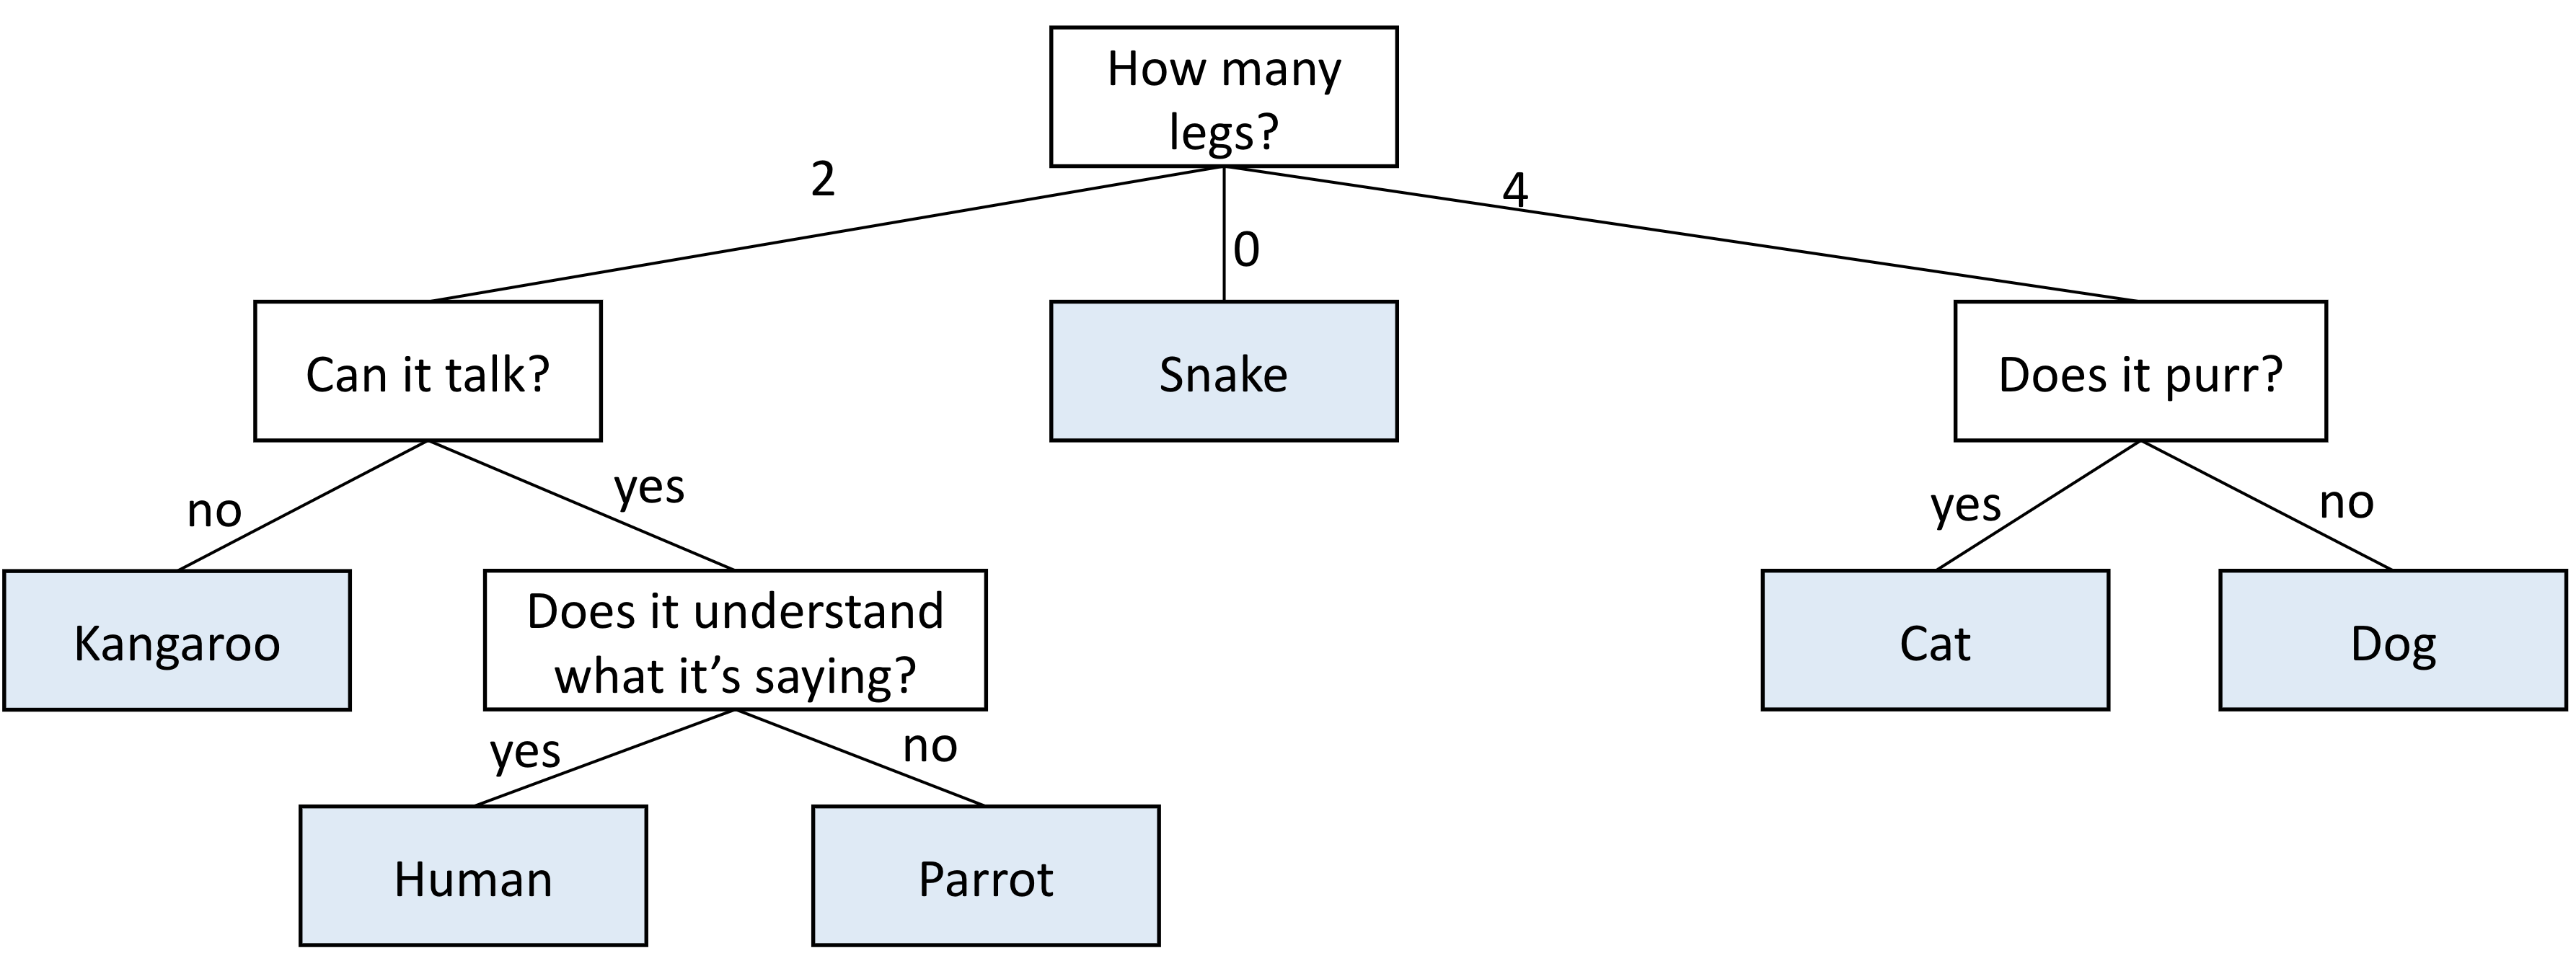

## 🌸 Why Use Decision Trees?

Decision trees offer several advantages:
- **Interpretability**: The tree can be visualized and decisions traced back.
- **Non-linearity**: They can model complex decision boundaries.
- **No scaling needed**: They don’t require normalization or standardization.
- **Handles mixed types**: Can deal with both categorical and continuous features.

However, they also have downsides:
- Easily **overfit** on training data.
- Small changes in data can lead to different trees.

We can implement a decision tree easily using sklearn. Like other models we’ve been working with in this class so far, we would create an instance of the model, fit it on our training data, and use it to make predictions.

In [3]:
iris= datasets.load_iris()
iris_data = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns= iris['feature_names'] + ['target']).astype({'target': int}) \
       .assign(species=lambda x: x['target'].map(dict(enumerate(iris['target_names']))))

In [4]:
decision_tree_model = tree.DecisionTreeClassifier(criterion='entropy')
decision_tree_model = decision_tree_model.fit(iris_data[["petal length (cm)", "petal width (cm)"]], iris_data["target"])

In [5]:
#Select some random rows from iris data to try with our model
#Hint use sample
four_random_rows = iris_data.sample(4)
four_random_rows
#

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
125,7.2,3.2,6.0,1.8,2,virginica
109,7.2,3.6,6.1,2.5,2,virginica
123,6.3,2.7,4.9,1.8,2,virginica
94,5.6,2.7,4.2,1.3,1,versicolor


In [6]:
decision_tree_model.predict(four_random_rows[["petal length (cm)", "petal width (cm)"]])

array([2, 2, 2, 1])

Our predictions seems to match real labels perfectly, lets visualize our tree with Graphviz

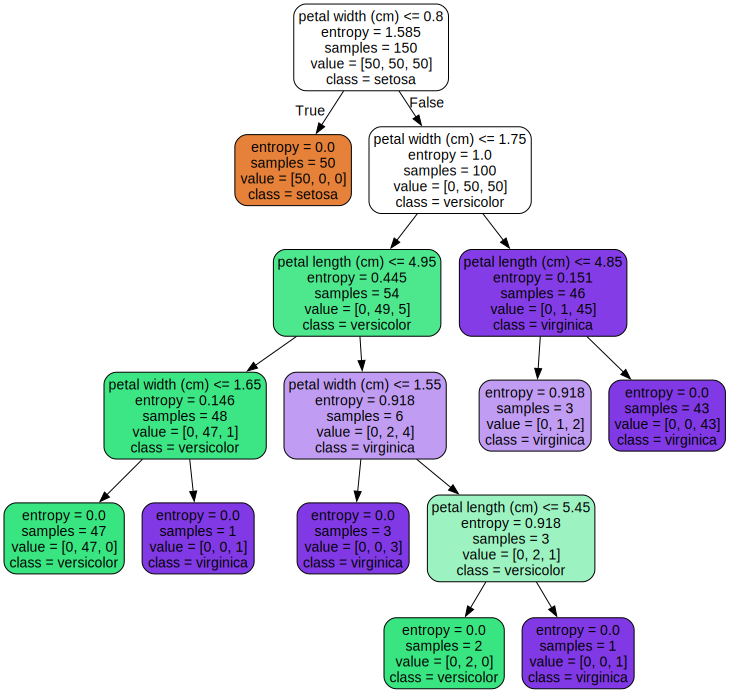

In [7]:

dot_data = tree.export_graphviz(decision_tree_model, out_file=None, 
                      feature_names=["petal length (cm)", "petal width (cm)"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
graph = graphviz.Source(dot_data)
graph

In each box (or node) of the decision tree, you’ll find:

1. The decision rule used to split the data at that node

2. The entropy value, which indicates the level of class impurity (we’ll explain this concept shortly)

3. The number of samples that have reached the node after all previous splits

4. The distribution of samples across classes at that node

5. The predicted class, which is the most frequent class among the samples (in case of a tie, the class listed first is chosen)

6. This visualization helps us understand exactly how the decision tree makes its classifications.
For instance, if an iris flower has a petal length less than or equal to 1.75, the tree would classify it as setosa.

Let’s now visualize the decision boundaries that this tree creates.



<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

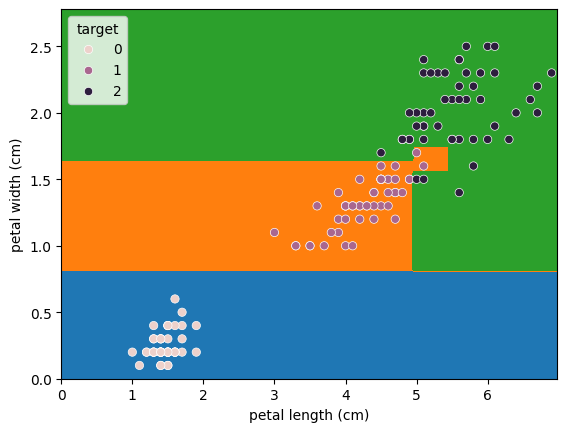

In [8]:

sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 7, 0.02),
                     np.arange(0, 2.8, 0.02))

Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)

#Draw a scatterplot where x will ne peta lenght and y petal width, and lets use color/hue to mapp species
sns.scatterplot(data = iris_data, x = "petal length (cm)", y="petal width (cm)", hue="target")
#

Now we will check how good our tree is on whole dataset

In [9]:
#Make a prediction, note you should use only part of columns used in training
predictions = decision_tree_model.predict(iris_data[["petal length (cm)", "petal width (cm)"]])
#

accuracy_score(predictions, iris_data["target"])

0.9933333333333333

Hmm, it looks like our decision tree didn’t achieve perfect accuracy. Why is that?

In general, decision trees without constraints tend to achieve perfect accuracy on the training set, unless two samples from different classes share exactly the same features. For example, if the one misclassified versicolor had a slightly longer petal length—say, 4.8001—the tree might have split differently and achieved 100% training accuracy.

However, this ability to perfectly fit the training data should raise a red flag. It’s a classic sign of overfitting. When a model fits every detail of the training set, it becomes too sensitive to small variations and performs poorly on new, unseen data. This is known as high variance.

Let’s look at an example that clearly illustrates overfitting.

Instead of using petal measurements, let’s train the tree on sepal measurements. If we plot these features, we’ll see that versicolor and virginica classes are much more intertwined than before—making it harder for the tree to separate them cleanly. This makes the tree more likely to overfit and less accurate overall.

<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

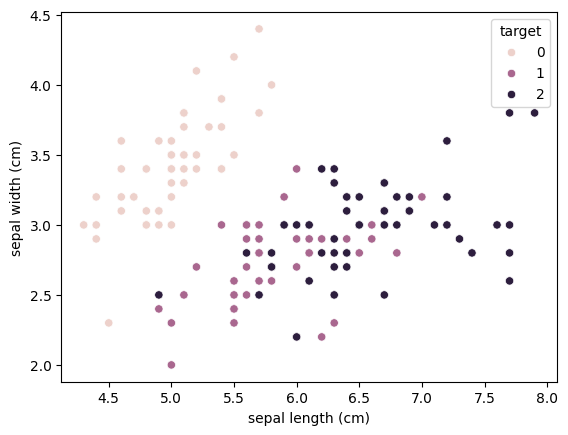

In [10]:
sns.scatterplot(data = iris_data, x = "sepal length (cm)", y="sepal width (cm)", hue="target", legend=True)

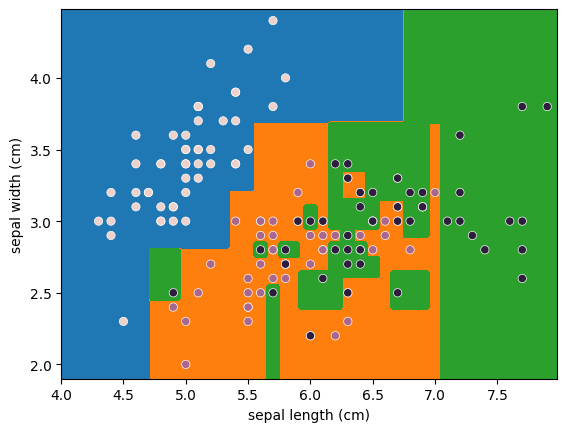

In [ ]:
sepal_decision_tree_model = tree.DecisionTreeClassifier(criterion="entropy")
#Train a model with sepal lenght and sepal width
sepal_decision_tree_model = sepal_decision_tree_model.fit(iris_data[["sepal length (cm)", "sepal width (cm)"]], iris_data["target"])
#Visualize the model with ListedColormap
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(4, 8, 0.02),
                     np.arange(1.9, 4.5, 0.02))

Z_string = sepal_decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse=True)
Z_int = Z_int 
Z_int = Z_int.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z_int, cmap=sns_cmap)
sns.scatterplot(data = iris_data, x = "sepal length (cm)", y="sepal width (cm)", hue="target", legend=False);

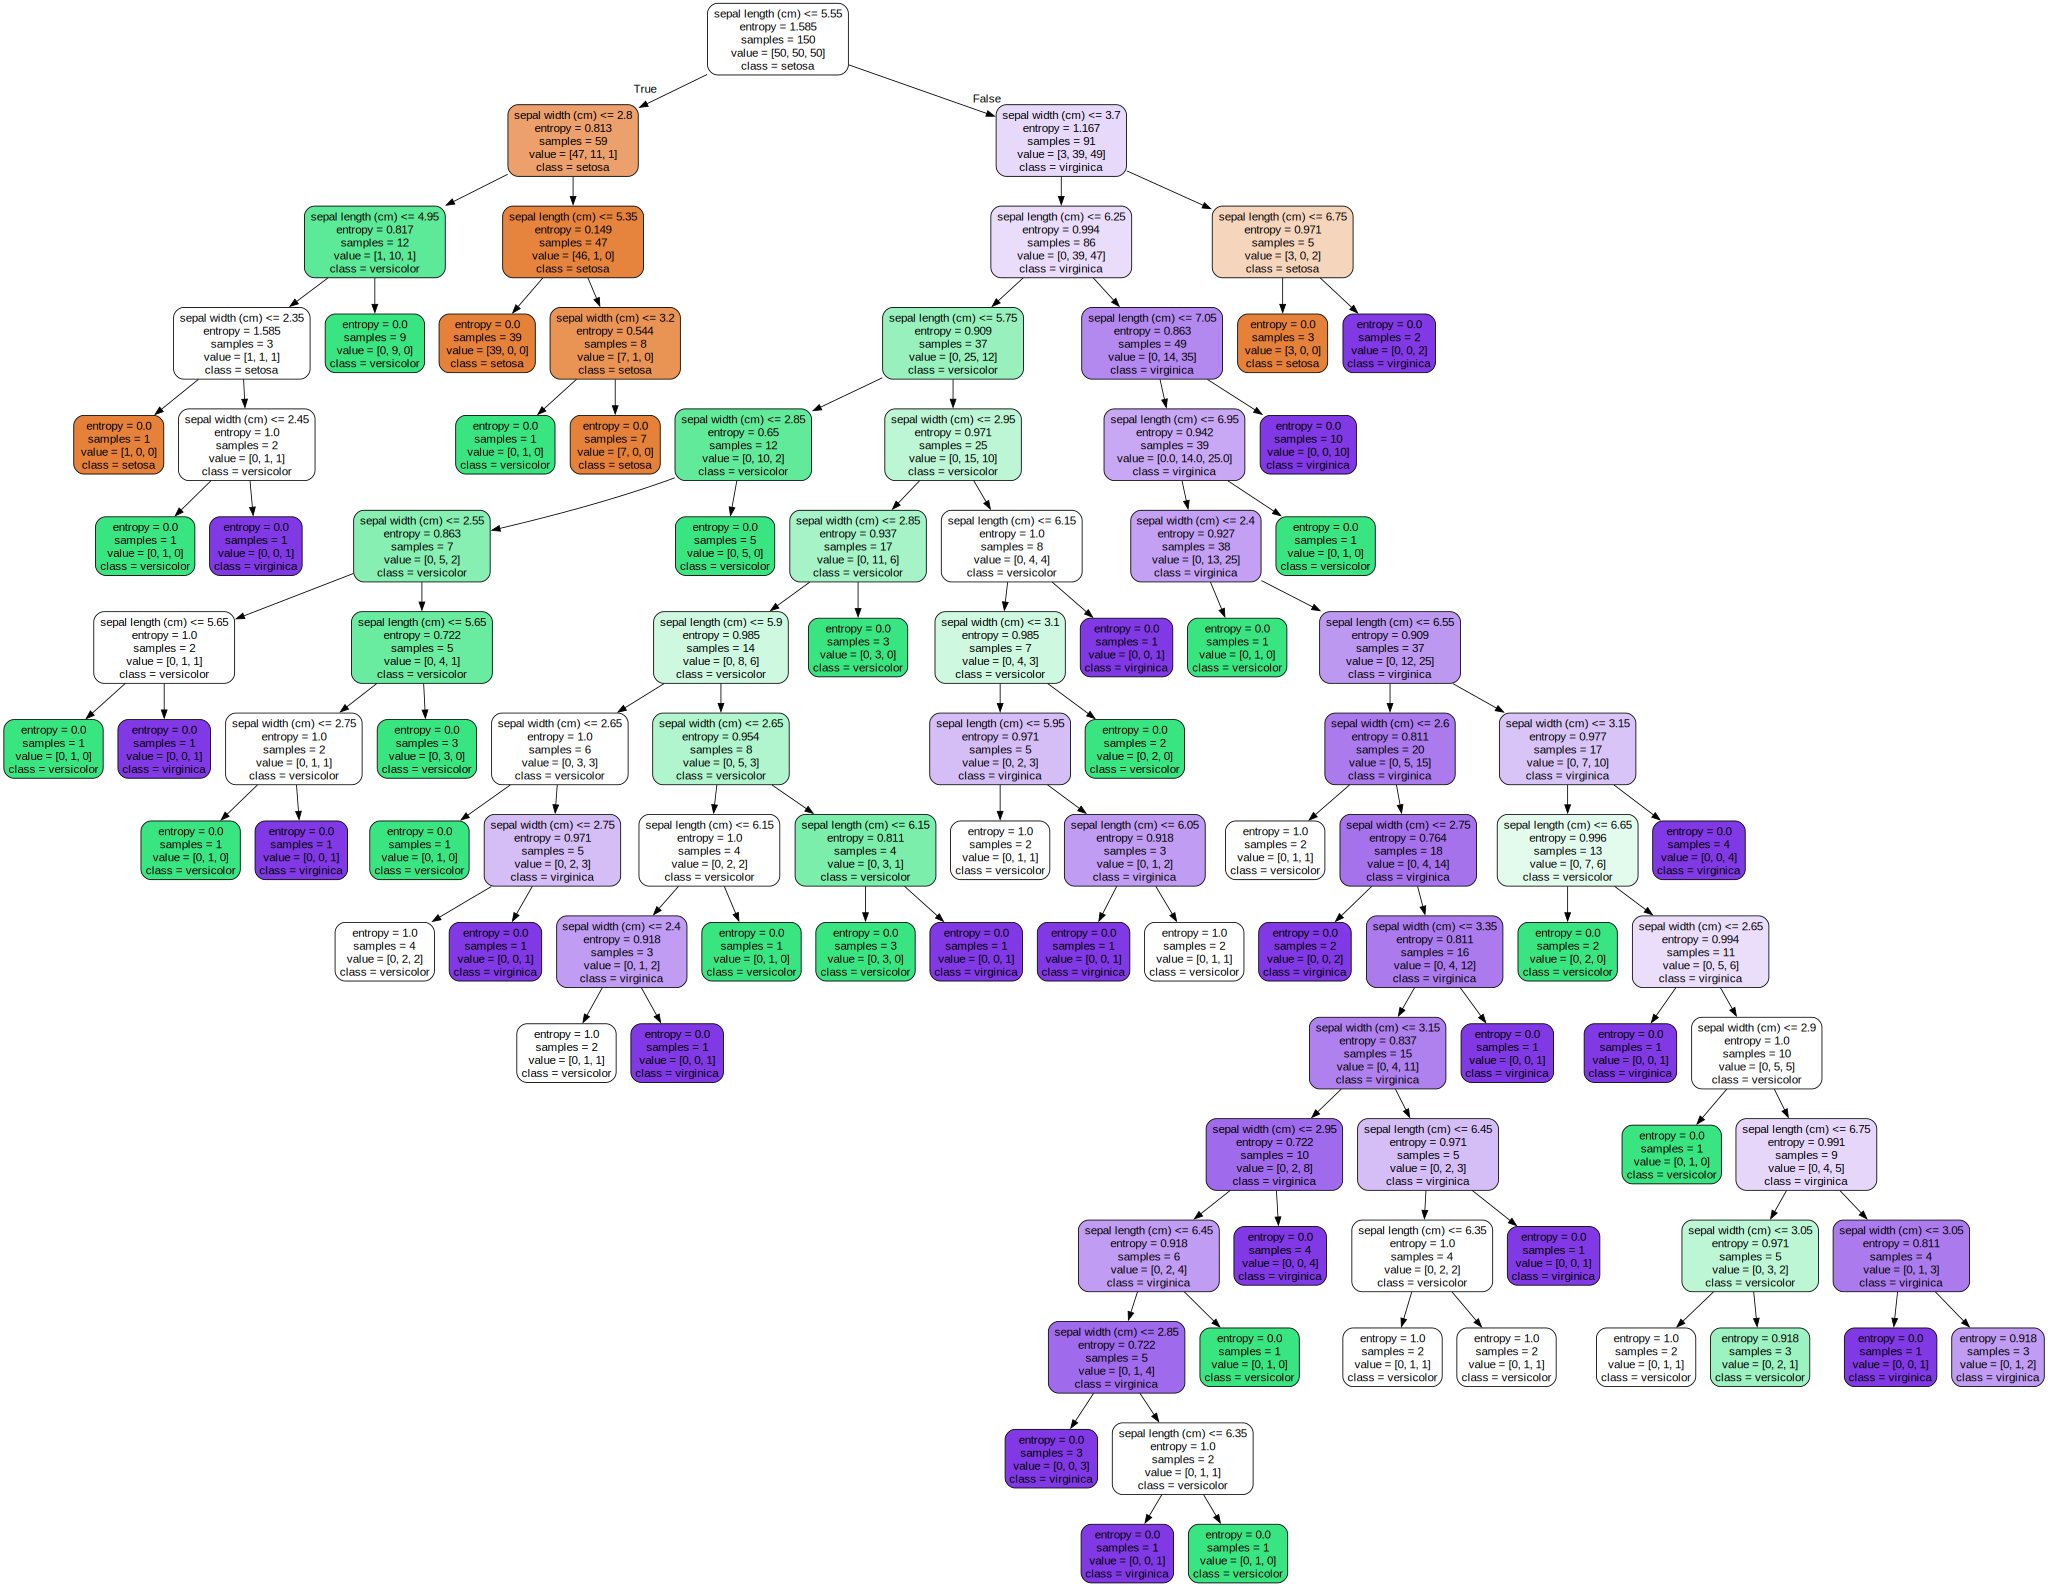

In [12]:
dot_data = tree.export_graphviz(sepal_decision_tree_model, out_file=None, 
                      feature_names=["sepal length (cm)", "sepal width (cm)"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
graph2 = graphviz.Source(dot_data)
graph2

To understand why our model overfits and what to do with it we need to understand how it was built, and what is entropy.

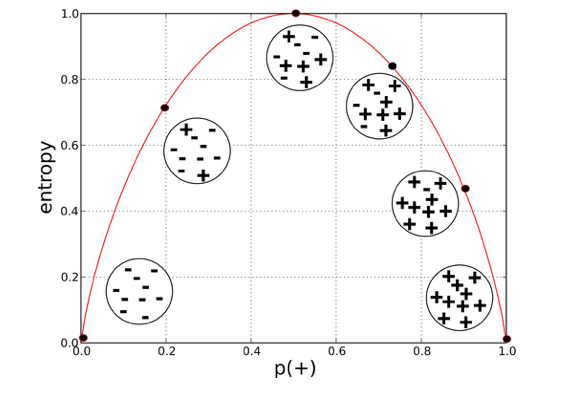!

Let 
 be the proportion of data points in a node belonging to class 
. For example, for the node at the top of the decision tree we saw earlier, there are 38 setosas, 37 versicolors, and 35 virginicas. So


\begin{align*}
&p_0 = 38/110 \approx 0.35\\
&p_1 = 37/110 \approx 0.34\\
&p_2 = 35/110 \approx 0.32.
\end{align*} 


With this, the entropy 
 of a node is defined as
 
\begin{align*}
S = -\sum_{C}p_C \log_{2}(p_C).
\end{align*} 

Notice we are using 
 a logarithm of base 2 here. This is the only place in the class we are using this particular 
; everywhere else 
 has base 
.

The term “entropy” comes from information theory and it measure how “unpredictable” or “chaotic” a system is. The bigger the entropy, the more unpredictable a node is. In particular.

A node where all data are part of the same class has zero entropy.
 bits.
A node where data are evenly split between two classes has entropy 1.
 bit.
A node where data are evenly split between 3 classes has entropy 1.58.
 bits.
A node where data are evenly split into C classes has entropy 
$-\sum_{C}p_C \log_{2}(p_C)$
 bits.

### Generating Trees with Entropy


How do we use entropy to generate a decision tree?

Decision trees are comprised of many different splits, so to generate a tree, we need to be able to come up with optimal splits given a node. To measure how good a split is, we use the weighted entropy.

Suppose a given split results in two nodes $X$ and $Y$ with $N_{1}$ and $N_{2}$ number of samples each. The loss (or weighted entropy) of that split is given by:
 
\begin{align*}
L = \frac{N_{1} S(X) + N_{2} S(Y)}{N_{1} + N_{2}}
\end{align*}
where $S(X)$ and $S(Y)$ are the entropies of nodes $N_{1}$ and $N_{2}$.

Intuitively, the weighted entropy of a split measures how unpredictable the result of the split is. We want to make the resulting nodes as predictable as possible, therefore we need to minimize the weighted entropy. In decision trees, the way we minimize the weighted entropy of a split is to try out different combinations of features and splitting values.

Now we have everything we need to state the decision tree generation algorithm.


A decision tree is simply a tree of questions that must be answered in a sequence to yield a predicted classification. For example, below is a classifier for animals. It starts by asking how many legs the animal has. If the answer is no, we immediately say snake. If the answer is four, the model is not quite sure, so we must ask an additional question: does it purr? If the answer is yes, the animal is a cat; and if the answer is no, the animal is a dog. The other possibility is that the number of legs was two, in that case we have up to two additional questions we may need to ask before eventually deciding if it is a kangaroo, human, or parrot. Obviously this decision tree does not cover all animals. In principle, with the right sequence of questions, we could build a giant decision tree that could differentiate a vast number of animals.


What do we mean by “pure” or “unsplittable”?

A node that has only samples from one class is called a “pure” node.
A node that has overlapping data points from different classes and thus that cannot be split is called “unsplittable”. We saw an example of this in our first decision tree, fitted with petal_length and petal_width.

A “fully grown” decision tree built with our algorithm runs the risk of overfitting. In linear models, we introduced the notion of “regularization”. However, regularization doesn’t make sense in the decision tree context as decision trees don’t have parameters that act as weights, so we can’t use $L_{1}$ or $L_{2}$ regularization. We have to come up with new ideas.
The first category of ideas is to disallow fully grown trees.

Since decision trees tend to come up with extremely specific rules to attempt to fit the training data perfectly, we can set one or more special rules to prevent the tree from fully growing.

Examples of this include:

Don’t split nodes with < 1% of the samples.
In sklearn, this hyperparameter is called “min_samples_split”.
Don’t allow nodes to be more than 7 levels deep in the tree.
In sklearn, this hyperparameter is called “max_depth”.

Another approach is to allow the tree to fully grow when fitting it, then cut off the less useful branches of the tree. In pruning the tree, we are usually looking for rules that affect only a small subset of points.

There are many ways to prune trees. One way is to use a validation set to see if keeping a given branch is worth it. Specifically, we run our model on the validation set twice, once keeping the branch, and the second time replacing the branch by its most common prediction. If there’s no or minimal impact on the validation error, then we delete the split. The idea here is that the split was not useful on unseen data.

Recall that when a node has multiple samples in it from different classes, the predict method will simply return the most common class, and the predict_proba method will return the fraction of samples that belong to each class.

Now lets try to prune our trees and check how good they will perfrom, since we already know about train/test split lets do everything from the beggining.

Firstly we will built simple full grown tree and visualize it.

Train Accuracy: 1.0
Test Accuracy: 0.9111111111111111


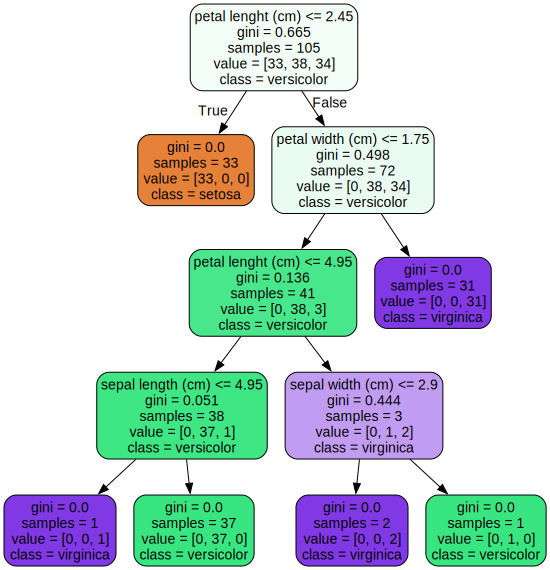

In [ ]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# make a train test split and train simple decision tree mode, then calculate its accuracy on train and on test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2025)

clf_full = DecisionTreeClassifier(random_state=2025)
clf_full.fit(X_train, y_train)

print("Train Accuracy:", accuracy_score(y_train, clf_full.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, clf_full.predict(X_test)))

#

full_data = tree.export_graphviz(clf_full, out_file=None, 
                      feature_names=["sepal length (cm)", "sepal width (cm)", "petal lenght (cm)", "petal width (cm)"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
fll_tree_graph = graphviz.Source(full_data)
fll_tree_graph

Now lets add a max depth parameters which regulates how deep tree can go. 
We will itterativly test values from 1 to 10 to find the best one.

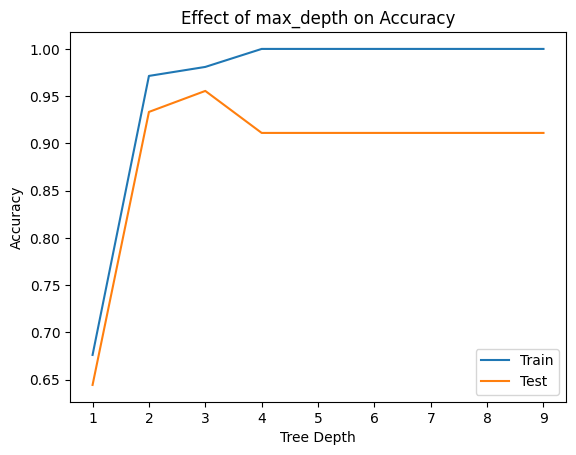

In [ ]:


train_acc = []
test_acc = []
depths = range(1, 10)

for d in depths:
    #Train model and store accuracy here, @hint use append
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))
    #

plt.plot(depths, train_acc, label="Train")
plt.plot(depths, test_acc, label="Test")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Effect of max_depth on Accuracy")
plt.show()


Lets select value we believe to be best(and why), and show a tree for it

Train Accuracy: 1.0
Test Accuracy: 0.9111111111111111


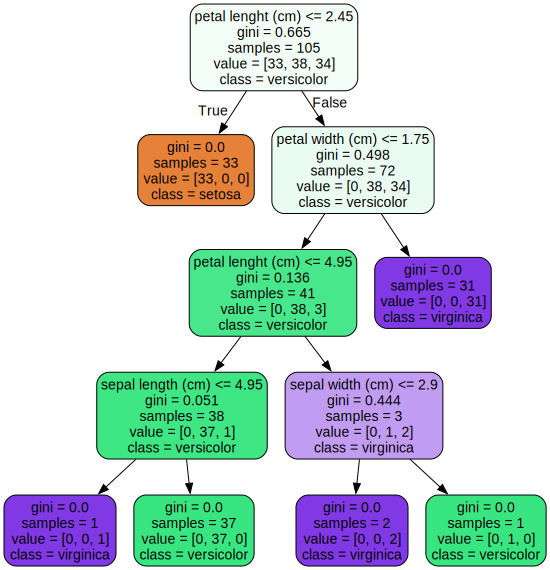

In [15]:
#Select best depth value and train a model
clf_pruned = DecisionTreeClassifier(random_state=42, max_depth=4)
clf_pruned.fit(X_train, y_train)
#

print("Train Accuracy:", accuracy_score(y_train, clf_pruned.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, clf_pruned.predict(X_test)))

pruned_data = tree.export_graphviz(clf_pruned, out_file=None, 
                      feature_names=["sepal length (cm)", "sepal width (cm)", "petal lenght (cm)", "petal width (cm)"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
pruned_tree_graph = graphviz.Source(pruned_data)
pruned_tree_graph

Now we will try another method names cost complexity pruning
Cost complexity pruning is a method used to simplify decision trees by removing branches that don't contribute significantly to its predictive power, thus mitigating overfitting and improving generalization. It involves introducing a cost complexity parameter (often denoted as alpha) to penalize larger trees and balancing this penalty with the tree's performance on a validation set. 
Here's a breakdown of the process:
1. Building the Full Tree:
A decision tree is grown to its maximum depth, potentially leading to overfitting on the training data. 
2. Defining the Cost Complexity Parameter (alpha):
Alpha is a tuning parameter that controls the trade-off between tree size and prediction accuracy. 
A higher alpha value leads to more pruning, resulting in a smaller, simpler tree. 
A lower alpha value results in a larger, more complex tree, potentially overfitting. 

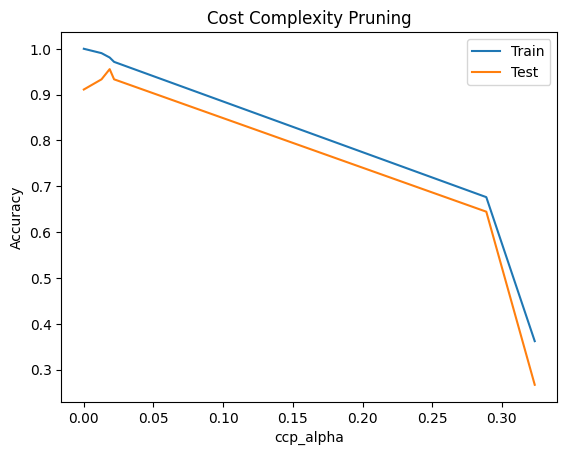

In [16]:
path = clf_full.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

train_scores = []
test_scores = []

#Find best cpp value
for alpha in alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
#
    
plt.plot(alphas, train_scores, label='Train')
plt.plot(alphas, test_scores, label='Test')
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Cost Complexity Pruning")
plt.legend()
plt.show()


And same here, lets select best ccp value and build a tree for it

Train Accuracy: 0.9714285714285714
Test Accuracy: 0.9333333333333333


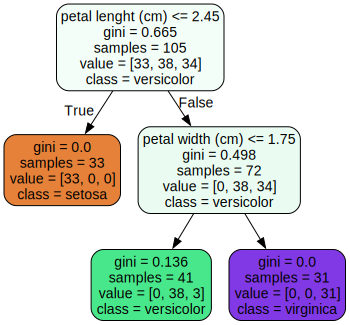

In [17]:
#Select best depth value and train a model
clf_ccp = DecisionTreeClassifier(random_state=42, ccp_alpha=0.025)
clf_ccp.fit(X_train, y_train)
#
print("Train Accuracy:", accuracy_score(y_train, clf_ccp.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, clf_ccp.predict(X_test)))

ccp_data = tree.export_graphviz(clf_ccp, out_file=None, 
                      feature_names=["sepal length (cm)", "sepal width (cm)", "petal lenght (cm)", "petal width (cm)"],  
                      class_names=["setosa", "versicolor", "virginica"],  
                      filled=True, rounded=True)  
ccp_tree_graph = graphviz.Source(ccp_data)
ccp_tree_graph

As we’ve seen earlier, a fully-grown decision tree will almost always overfit the data. It has low model bias, but high model variance. In other words, small changes in the dataset will result in very a different decision tree. As an example, the two models below are trained on different subsets of the same data. We can see they come out very differently.

Two trees fitted on different subset of the same dataset

The idea of random forest is to harness this variance: build many decision trees and take the majority vote.

To build multiple decision trees using our training data, we use our old friend bootstrap. In particular, this method is called “bagging”, which stands for Bootstrap Aggregating. In bagging, we generate bootstrap resamples of training data.
Fit one model for each resample.
Build the final model using the average predictions of each small model.
However, bagging is usually not enough to reduce model variance. In many cases, the different decision trees end up looking very similar to one another and therefore make similar predictions. The resulting model will still have low bias and high variance.

To improve on bagging, we add another layer of randomness by only using a random subset of 
 features at each split. Usually we use 
 for decision tree classifiers, where 
 is the total number of features.

The algorithm will create individual trees, each overfit in a different way. The hope is then that the overall forest will have low variance due to aggregation.

Now we will try to build random forest and compare it to our decision tree model


For this task we will use new data from Kaggle famous hub for DS and ML
This data describes two species of pumpkin and specifically their seeds, in terms of their shape. 
To download data we can use kagglehub package 

In [18]:

path = kagglehub.dataset_download("muratkokludataset/pumpkin-seeds-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\levkr\.cache\kagglehub\datasets\muratkokludataset\pumpkin-seeds-dataset\versions\1


Based on your system you might need to adjsut this path
And then lets check if there is any NA in data

In [ ]:

#Load the data and inspect it
df = pd.read_excel(r"C:\Users\levkr\.cache\kagglehub\datasets\muratkokludataset\pumpkin-seeds-dataset\versions\1\Pumpkin_Seeds_Dataset\Pumpkin_Seeds_Dataset.xlsx")
#print(df.isnull().sum())
#

In [ ]:
#Do a train test split
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=0.2)
#

In [21]:
# train Decision Tree 
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
print("Decision Tree:\n", classification_report(y_test, dt.predict(X_test)))
#



# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Random Forest:\n", classification_report(y_test, rf.predict(X_test)))


Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30




Now lets try to enhance our model there is a lot of ways to do it, but when we cannot provide more data, the best way is to make our model fit better
To do it we can try to select the most appopriate set of parameters to do it.
Then we will evaluate model by training it for each set of parameters.



| Hyperparameter      | Description                                                | Typical Values                                                | Explanation                                                                                                            |
| ------------------- | ---------------------------------------------------------- | ------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| `n_estimators`      | Number of trees in the forest                              | `100`, `200`, `500`, `1000`                                   | More trees generally improve performance but increase training time. Diminishing returns after a point.                |
| `max_depth`         | Maximum depth of each tree                                 | `None`, `5`, `10`, `20`, `50`                                 | Limits how deep each tree can grow. Deeper trees can overfit; shallow trees might underfit.                            |
| `min_samples_split` | Minimum number of samples required to split a node         | `2`, `5`, `10`, `20`                                          | Larger values prevent splitting small groups and reduce overfitting.                                                   |
| `min_samples_leaf`  | Minimum number of samples required at a leaf node          | `1`, `2`, `4`, `10`                                           | Larger values force the model to make broader, more general decisions at leaves. Helps regularize.                     |
| `max_features`      | Number of features to consider at each split               | `'auto'`, `'sqrt'`, `'log2'`, `None`, float (e.g. `0.8`)      | Controls randomness. `'sqrt'` is common for classification. Lower values decorrelate trees more, reducing overfitting. |
| `bootstrap`         | Whether bootstrap samples are used                         | `True`, `False`                                               | If `False`, all trees are trained on the same data, which reduces randomness. Normally kept `True`.                    |
| `oob_score`         | Use out-of-bag samples to estimate generalization          | `True`, `False`                                               | When `bootstrap=True`, out-of-bag samples can be used like cross-validation.                                           |
| `class_weight`      | Adjust weights inversely proportional to class frequencies | `None`, `'balanced'`, `'balanced_subsample'`, `{0: 1, 1: 10}` | Especially useful for imbalanced datasets. `'balanced'` automatically adjusts weights.                                 |
| `ccp_alpha`         | Post-pruning complexity parameter                          | `0.0`, `0.01`, `0.001`, etc.                                  | Enables cost complexity pruning (like with decision trees) for each individual tree in the forest.                     |
| `n_jobs`            | Number of cores to use during training                     | `-1`, `2`, `4`                                                | `-1` uses all available CPU cores. Speeds up training for large forests.                                               |
| `random_state`      | Random seed for reproducibility                            | `42`, `0`, any int                                            | Ensures reproducible results across runs.                                                                              |
| `verbose`           | Controls how much output you see during training           | `0`, `1`, `2`                                                 | Helps monitor training progress, especially with many trees.                                                           |


In [ ]:

param_grid = {
    'n_estimators': [10, 15, 25, 50, 75,  100, 200],
    'max_depth': [3, 4, 5,  7, 10, 15, None],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 3,  4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid = GridSearchCV(RandomForestClassifier(random_state=2025),
    param_grid,
    cv=5, # here we need specify how many folds we will be using
    scoring='accuracy', # and here how we will evaluate our model
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Accuracy Score (CV):", grid.best_score_)


Fitting 5 folds for each of 3136 candidates, totalling 15680 fits
Best Params: {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Best Accuracy Score (CV): 0.9583333333333334


Lets visualize results of our best model with the conf matrix
We see that overall accuracyof the model becomes slightly better

Final Evaluation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



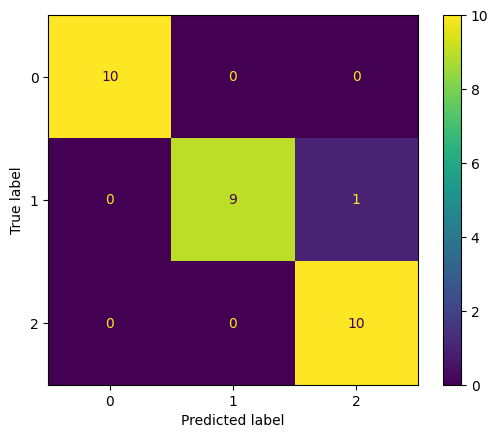

In [23]:
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

print("Final Evaluation:\n", classification_report(y_test, y_pred))
#Lets do a confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot()
#


Lastly we can check how important each feature is for our model

Understanding Feature Importance in Random Forests
One of the strengths of Random Forests is their ability to measure feature importance — that is, how useful each feature is in making accurate predictions.

 What is Feature Importance?
Feature importance refers to a score assigned to each feature based on how much it improves the model's splitting criterion (like entropy we discuss previously) across all the trees in the forest.

In essence, a feature is considered more important if:

It is used in more trees, and/or

It contributes to larger reductions in impurity when used to split data

How is It Calculated?
For each decision tree in the forest:

Every time a feature is used to split a node, it contributes to reducing impurity.

This reduction in impurity is recorded and summed across all splits and all trees.

The result is normalized, so that the importance scores across all features sum to 1.0.


Interpreting Feature Importance
A higher importance score means the feature is more influential in prediction.

A score of 0 means the feature was never used in any split in the forest.
Use plots to quickly identify the top contributors.


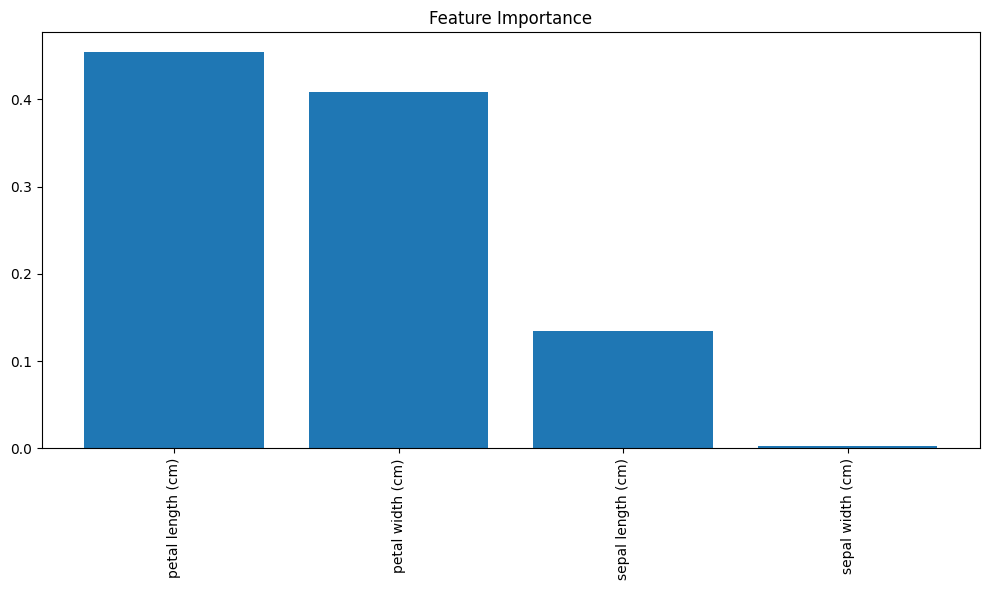

In [ ]:


importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


If we have enough time then lets try to build the best RF model possibly using diamonds dataset - you will need predict price from other characteristcis of diamond

In [ ]:

import os

path = kagglehub.dataset_download("amirhosseinmirzaie/diamonds-price-dataset")
print("Path to dataset files:", path)

#You are free to experiment here
csv_path = os.path.join(path, "diamonds.csv")

# Читання CSV-файлу
df = pd.read_csv(csv_path)

# Перевірка
print(df.head())


#

Path to dataset files: C:\Users\levkr\.cache\kagglehub\datasets\amirhosseinmirzaie\diamonds-price-dataset\versions\1
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


### Otherwise lets have a break, and then proceed with NN
🥳
⎛⎝ ≽  >  ⩊   < ≼ ⎠⎞

Neural Network in Keras
### Theoretical Background: Neural Networks 
A neural network (NN) is a computational model inspired by the way biological neural networks in the human brain process information. It consists of layers of interconnected nodes (neurons), where each node represents a simple computation.
Neural networks are used to model complex patterns and prediction problems. In this example, we will work with the MNIST dataset, which consists of handwritten digits. We will build a simple neural network using Keras for classification.

### Key components of a neural network:

1. **Input Layer**:

   * The input layer is the first point of entry for the data. In the case of MNIST, the input data consists of 28x28 pixel grayscale images representing digits. Each pixel is a feature (a value between 0 and 255) that needs to be normalized for efficient processing by the network.
   * **Preprocessing**: Each pixel is typically normalized by dividing the pixel value by 255, transforming it to a range between 0 and 1. This helps the network converge faster and ensures that the learning process is stable.

2. **Hidden Layers**:

   * Hidden layers perform computations that transform the input data into representations that help with decision-making. These transformations are performed using **activation functions**, which introduce non-linearity into the network. Non-linearity is crucial because it allows the network to model complex relationships in the data.
   * Each hidden layer consists of neurons, which apply a weighted sum of inputs followed by an activation function. The output from one layer becomes the input for the next layer.

3. **Output Layer**:

   * The output layer provides the model's prediction. In the case of classification, such as MNIST, the output layer has a neuron for each class (10 neurons for digits 0-9). The activation function in the output layer typically produces a probability distribution over the classes, and the class with the highest probability is the predicted digit.

### Detailed Explanation of the Components:

#### Activation Functions:

Activation functions are mathematical functions that determine the output of neurons. They help networks capture and model non-linear patterns in the data. Some of the commonly used activation functions are:

* **ReLU (Rectified Linear Unit)**:

  * **ReLU** is the most widely used activation function in deep learning. It works by setting all negative values in the input to zero while keeping positive values as is. This introduces non-linearity and allows the network to learn complex features.
  * **Mathematical Formulation**:

    $$
    \text{ReLU}(x) = \max(0, x)
    $$
  * **Advantages**: Faster training, helps mitigate the vanishing gradient problem, and avoids the saturation of neurons (which can happen with sigmoid and tanh).

* **Sigmoid**:

  * The **sigmoid** function is another activation function that squashes input values to a range between 0 and 1. It is historically popular but is less commonly used in hidden layers today due to problems like vanishing gradients for deep networks.
  * **Mathematical Formulation**:

    $$
    \text{Sigmoid}(x) = \frac{1}{1 + e^{-x}}
    $$

* **Tanh (Hyperbolic Tangent)**:

  * **Tanh** is another activation function that outputs values between -1 and 1. It works well for many tasks but has similar issues to sigmoid, particularly with deep networks.
  * **Mathematical Formulation**:

    $$
    \text{Tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
    $$

* **Softmax**:

  * **Softmax** is typically used in the output layer for multi-class classification tasks like MNIST. It converts the raw output of the network (logits) into a probability distribution over the classes, with each output neuron representing the likelihood of each class.
  * **Mathematical Formulation**:

    $$
    \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{N} e^{z_j}}
    $$

  where $z_i$ is the raw output (logit) for class $i$, and $N$ is the total number of classes.

#### Loss Function:

* The **loss function** measures the discrepancy between the model's predicted output and the actual target (true label). The objective of training is to minimize this loss function.
* For classification tasks like MNIST, **sparse categorical cross-entropy** is commonly used. It compares the predicted class probabilities to the true class labels and computes the error accordingly.

#### Optimization Methods:

**Optimization** is the process of adjusting the weights of the network to minimize the loss function. The gradient descent algorithm is the most popular optimization method.

* **Stochastic Gradient Descent (SGD)**:

  * **SGD** updates the model weights iteratively based on the gradient of the loss function with respect to the weights. The gradient tells the optimizer which direction to move the weights to minimize the loss.
  * The **learning rate** (denoted as $\eta$) controls the size of the steps taken during each update. A small learning rate can lead to slow convergence, while a high learning rate can make the training unstable.
  * **Mathematical Update Rule**:

    $$
    w_{new} = w_{old} - \eta \cdot \nabla L(w)
    $$

    where $\nabla L(w)$ is the gradient of the loss with respect to the weights.

* **Adam (Adaptive Moment Estimation)**:

  * **Adam** is an advanced optimizer that combines ideas from both **Momentum** and **RMSprop**. It adapts the learning rate based on the first and second moments (mean and variance) of the gradients.
  * Adam is particularly well-suited for problems with noisy gradients and for dealing with sparse data. It dynamically adjusts the learning rate during training, helping with faster convergence.
  * **Advantages of Adam**:

    * Automatically adapts the learning rate.
    * Handles noisy gradients better than SGD.
    * Typically requires less tuning for hyperparameters.

* **RMSprop**:

  * RMSprop is an adaptive learning rate optimization algorithm that adjusts the learning rate for each parameter based on a running average of recent gradient magnitudes. It is often used when the gradient updates are noisy.

### Backpropagation:

* **Backpropagation** is the algorithm used to compute the gradient of the loss function with respect to each weight in the network. It consists of two passes:

  1. **Forward Pass**: The input data is passed through the network to compute the output.
  2. **Backward Pass**: The gradient of the loss function is computed by applying the chain rule and propagated backward through the network. The weights are then updated using the computed gradients.

### Training Process:

* The **training process** involves passing data through the network (forward pass), computing the loss (error), and updating the weights using backpropagation. This process is repeated for multiple **epochs**. Each epoch is one complete pass over the entire training dataset.

  * **Epochs**: The number of iterations over the entire dataset. Too few epochs can result in underfitting, while too many can lead to overfitting.

  * **Batch Size**: Refers to the number of samples processed together before the model's weights are updated. Larger batch sizes can speed up training, but smaller batch sizes offer more noise and better generalization.

### Why Normalize Data?

* **Normalization** ensures that the data is on a similar scale, which helps the optimization process. For images, normalization typically involves scaling pixel values between 0 and 1 by dividing by 255.
* Normalization helps prevent large input values from disproportionately affecting the weight updates, leading to faster convergence and better overall training performance.

### Hyperparameters:

* **Learning Rate**: Controls how much the weights are adjusted during each update. A smaller learning rate may take longer to converge but helps find the global minimum, while a larger learning rate may converge faster but risk overshooting the optimal point.
* **Epochs**: The number of times the model will iterate over the entire training dataset.
* **Batch Size**: Affects the speed of training and the stability of weight updates.


In [ ]:

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD  # Stochastic Gradient Descend 
from matplotlib import pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD  # Stochastic Gradient Descend 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization


Load the data
### Loading and Preprocessing the Data The MNIST dataset consists of 60,000 training images and 10,000 testing images, each representing a digit (0-9). The images are 28x28 grayscale pixel values.
We will load the dataset using Keras' built-in function mnist.load_data(), which automatically splits the data into training and validation sets. The data is then normalized (scaled to values between 0 and 1) to improve the performance of the neural network.

In [ ]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

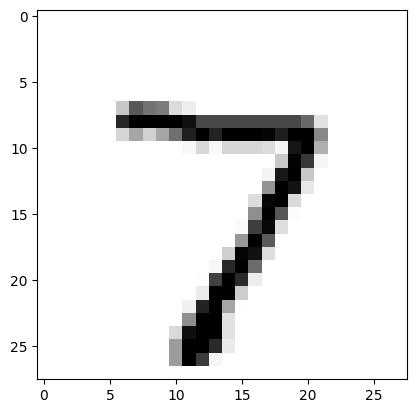

In [ ]:
plt.imshow(X_valid[0], cmap='Greys')

In [ ]:
#inspect shape of x and y
X_train.shape

(60000, 28, 28)

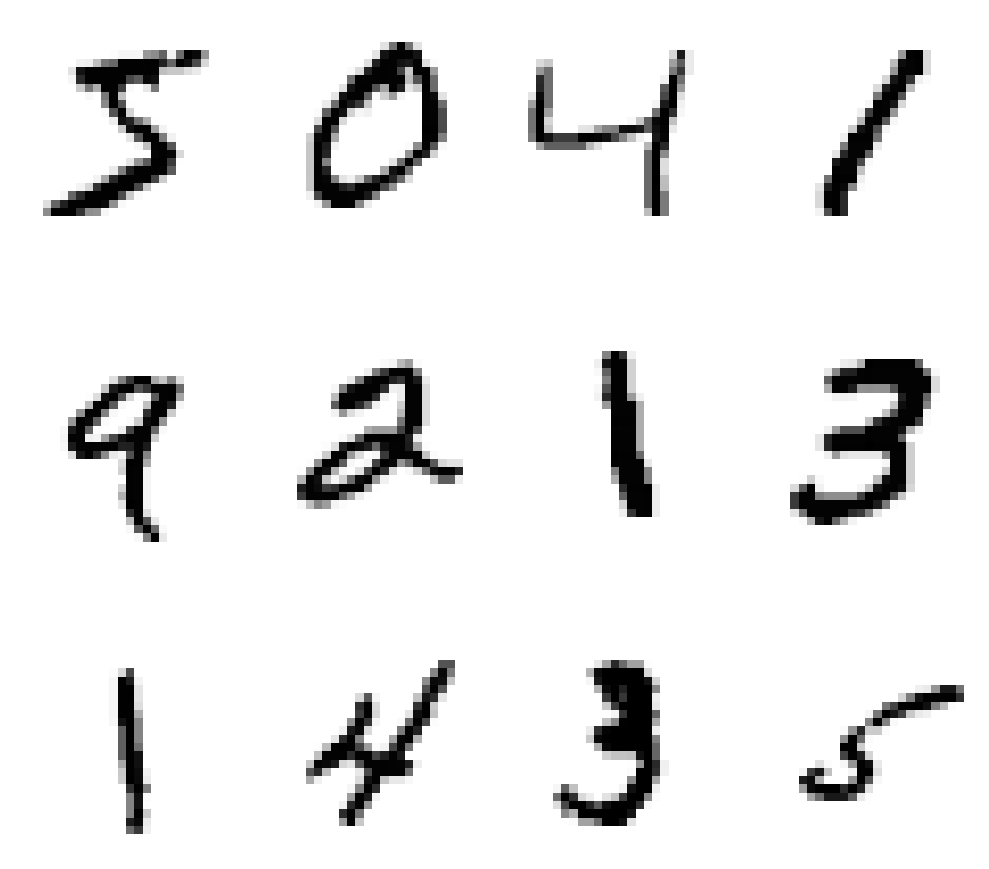

In [ ]:
plt.figure(figsize=(10,10))
for k in range(12):
    plt.subplot(3, 4, k+1)
    plt.imshow(X_train[k], cmap='Greys')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten the input layer
X_train = X_train.reshape(-1, 28*28)  # Flatten the images to vectors
X_valid = X_valid.reshape(-1, 28*28)

In [ ]:
# show shape of X_train
X_train.shape

(60000, 784)

In [ ]:
# Normalize the data
X_train = X_train.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# Create the neural network model with flattened input
model = Sequential([
    Dense(128, activation='relu', input_shape=(28*28,)),  # Hidden layer with ReLU, input should follow lenght of vector in x_train
    #How many neurons in hidden layer?  # 128 is a common choice, but you can experiment with different values
    #relu - activation function(give non-linearity)
    #what is length of vector in x_train?  # 28*28 = 784, since each image is 28x28 pixels
    Dense(10, activation='softmax')  # Output layer for classification (10 classes) 
    #how many neurons in output layer?  # 10, since we have 10 classes (digits 0-9)
    #softmax - activation function for multi-class classification gives probabilities for each class
])

# Compile the model
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# sgd - Stochastic Gradient Descent, a common optimizer for training neural networks
# sparse_categorical_crossentropy - loss function for multi-class classification when labels are integers

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)
#batch_size - number of samples processed before the model is updated, 32 is a common choice
# validation_data - data used to evaluate the model after each epoch, helps to monitor overfitting

# Evaluate the model
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)
# verbose=2 - prints detailed information about the evaluation process
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6637 - accuracy: 0.8318 - val_loss: 0.3614 - val_accuracy: 0.9012
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3415 - accuracy: 0.9030 - val_loss: 0.2963 - val_accuracy: 0.9160
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2925 - accuracy: 0.9168 - val_loss: 0.2630 - val_accuracy: 0.9261
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2610 - accuracy: 0.9261 - val_loss: 0.2384 - val_accuracy: 0.9349
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2367 - accuracy: 0.9331 - val_loss: 0.2182 - val_accuracy: 0.9397
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2168 - accuracy: 0.9391 - val_loss: 0.2036 - val_accuracy: 0.9414
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2005 - accuracy: 0.9437 - val_loss: 0.1891 - val_accuracy:

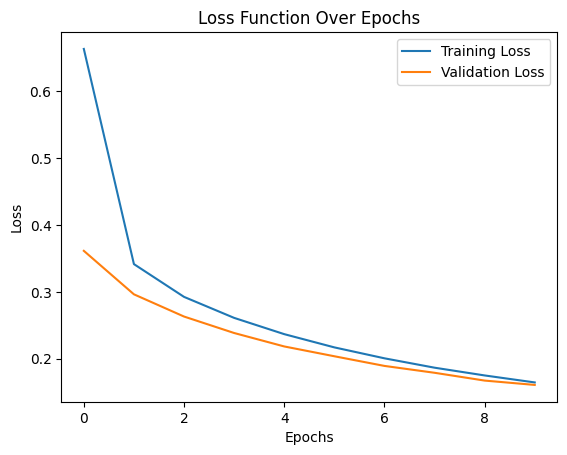

In [ ]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:

# Create your own model with different set of layers, then compile it and evaluate
model = Sequential([

])



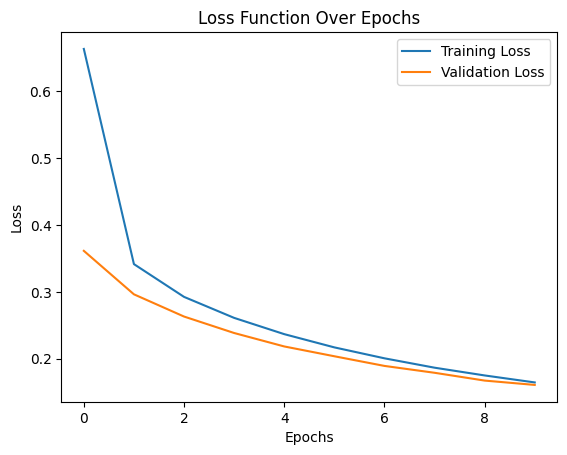

In [ ]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_valid)

313/313 [==============================] - 0s 1ms/step


Prediction:  490 Confidence:  1.0
Actual value:  0


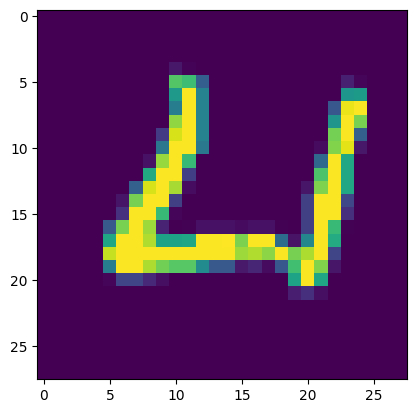

In [ ]:
## Show the prediction for a specific sample
n = 33
print("Prediction: ", y_pred[n].argmax(), "Confidence: ", np.amax(y_pred[0]))
print("Actual value: ", y_valid[n].argmax())
plt.imshow(X_valid[n].reshape(28,28))

In [ ]:
y_pred[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
# show prediction for another sample
n = 1
print("Prediction: ", y_pred[n].argmax(), "Confidence: ", np.amax(y_pred[n]))
print("Actual value: ", y_valid[n].argmax())

Prediction:  97 Confidence:  1.0
Actual value:  0


| **Layer**                         | **Description**                                                                                    | **When to Use**                                                                                                       | **Example**                                                      |
| --------------------------------- | -------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------- |
| **Dense**                         | Fully connected layer where every neuron is connected to every neuron in the previous layer.       | Commonly used in most neural networks, especially for simple feedforward networks.                                    | `Dense(128, activation='relu')`                                  |
| **Conv2D**                        | Convolutional layer that applies convolution operations to the input (mainly used for image data). | Used in Convolutional Neural Networks (CNNs) for image classification, object detection, etc.                         | `Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))` |
| **MaxPooling2D**                  | Reduces the spatial dimensions (height and width) by taking the maximum value in each patch.       | Used after convolutional layers to downsample the image, reducing computational load and helping prevent overfitting. | `MaxPooling2D(pool_size=(2, 2))`                                 |
| **Flatten**                       | Flattens the multi-dimensional input into a 1D array to pass it to fully connected layers.         | Used after convolutional or pooling layers to prepare the data for dense layers.                                      | `Flatten()`                                                      |
| **Dropout**                       | Randomly sets a fraction of input units to zero to prevent overfitting.                            | Used to prevent overfitting in deep networks by randomly ignoring neurons during training.                            | `Dropout(0.2)`                                                   |
| **BatchNormalization**            | Normalizes the input to each layer by adjusting and scaling activations.                           | Helps stabilize learning by reducing internal covariate shift and allows for faster training.                         | `BatchNormalization()`                                           |
| **LSTM (Long Short-Term Memory)** | A type of recurrent layer designed to handle sequences by remembering long-range dependencies.     | Used in sequence models such as time-series forecasting, speech recognition, and NLP tasks.                           | `LSTM(128, input_shape=(timesteps, features))`                   |
| **GRU (Gated Recurrent Unit)**    | A simpler variant of LSTM, designed for sequence modeling tasks.                                   | Useful for sequential data and can be more efficient than LSTM for certain tasks.                                     | `GRU(128, input_shape=(timesteps, features))`                    |
| **Embedding**                     | Turns positive integers into dense vectors of fixed size.                                          | Used in NLP tasks to convert word indices into dense word embeddings.                                                 | `Embedding(input_dim=10000, output_dim=128, input_length=200)`   |
| **GlobalAveragePooling2D**        | Computes the average of the entire spatial dimension (used in CNNs).                               | Used in CNN architectures to reduce the spatial dimensions before passing to the output layer.                        | `GlobalAveragePooling2D()`                                       |
| **GlobalMaxPooling2D**            | Similar to GlobalAveragePooling2D but computes the maximum value across the spatial dimensions.    | Used to reduce the dimensionality of feature maps, especially in CNNs for image classification tasks.                 | `GlobalMaxPooling2D()`                                           |
| **Reshape**                       | Reshapes the input tensor to a different shape.                                                    | Used when you need to change the shape of data for compatibility between layers.                                      | `Reshape((28, 28, 1))`                                           |
| **UpSampling2D**                  | Increases the spatial dimensions of the input by a specified factor.                               | Used in tasks like image generation (e.g., GANs) or segmentation, where the image size needs to be upsampled.         | `UpSampling2D(size=(2, 2))`                                      |
| **SeparableConv2D**               | A depthwise separable convolution, which is more efficient than standard convolutions.             | Used for faster computations in CNNs, especially for mobile or embedded applications.                                 | `SeparableConv2D(32, (3, 3), activation='relu')`                 |


In [ ]:
# Reshape the input data for Conv2D layers (add channel dimension)
X_train = X_train.reshape(-1, 28, 28, 1)  # Reshape for Conv2D: (batch_size, height, width, channels)
X_valid = X_valid.reshape(-1, 28, 28, 1)

# Normalize the data
X_train = X_train.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255

# Create the neural network model with multiple layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # Convolutional layer
    MaxPooling2D(pool_size=(2, 2)),  # MaxPooling layer
    Flatten(),  # Flatten the input for the dense layer
    Dense(128, activation='relu'),  # Dense hidden layer with ReLU
    Dropout(0.2),  # Dropout layer to prevent overfitting
    BatchNormalization(),  # Batch normalization layer
    Dense(10, activation='softmax')  # Output layer for classification (10 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")



Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4249 - accuracy: 0.8740 - val_loss: 0.1976 - val_accuracy: 0.9409
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2217 - accuracy: 0.9332 - val_loss: 0.1337 - val_accuracy: 0.9619
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1737 - accuracy: 0.9473 - val_loss: 0.1021 - val_accuracy: 0.9680
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1456 - accuracy: 0.9553 - val_loss: 0.0866 - val_accuracy: 0.9718
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1228 - accuracy: 0.9622 - val_loss: 0.0803 - val_accuracy: 0.9745
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1081 - accuracy: 0.9665 - val_loss: 0.0729 - val_accuracy: 0.9778
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0973 - accuracy: 0.9694 - val_loss: 0.0724 - val_accura